In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from scipy.optimize import minimize
import pandas as pd
from scipy.stats import poisson, uniform, expon, pareto
from tqdm import tqdm
from mdptoolbox import mdp, util
import itertools
from scipy.sparse import csr_matrix, lil_matrix
from matplotlib.patches import Patch
import math
import random
import sympy as sp
from sympy.printing.latex import print_latex

# stationary dist

In [79]:
p0, p0p, p1, p0pp = sp.symbols('p_0 p_{00} p_1 p_{000}')
a, b, x, g, p, C, E, ell  = sp.symbols('a b x g p C E lambda')

In [80]:
# p_i is the stationary distribution for State i
p0    = p1 / (a*(1-p)*(1-sp.exp(-(b-C)/(1-ell))) + a*p*(1-sp.Min(sp.exp(-(b-C-E)/(1-ell)),1)))
p0p   = p1 * (1-a)
p0pp  = p1 * a
p2    = p1*(a/(1-a))
prest = p1*a/(1-2*a)

In [81]:
eq = sp.Eq(p0+p0p+p0pp+prest+p1, 1)
p1_sym = sp.solve(eq, p1)[0]

In [82]:
p1_sym

a*(2*a*p*exp((-C + b)/(lambda - 1)) - 2*a*p*Min(1, exp((-C - E + b)/(lambda - 1))) - 2*a*exp((-C + b)/(lambda - 1)) + 2*a - p*exp((-C + b)/(lambda - 1)) + p*Min(1, exp((-C - E + b)/(lambda - 1))) + exp((-C + b)/(lambda - 1)) - 1)/(3*a**2*p*exp((-C + b)/(lambda - 1)) - 3*a**2*p*Min(1, exp((-C - E + b)/(lambda - 1))) - 3*a**2*exp((-C + b)/(lambda - 1)) + 3*a**2 - 2*a*p*exp((-C + b)/(lambda - 1)) + 2*a*p*Min(1, exp((-C - E + b)/(lambda - 1))) + 2*a*exp((-C + b)/(lambda - 1)) - 1)

In [83]:
p1_me = (1/(a*(1-p)*(1-sp.exp(-(b-C)/(1-ell))) + a*p*(1-sp.Min(sp.exp(-(b-C-E)/(1-ell)),1))) + 1+ (1-a)/(1-2*a))**(-1)
p1_sym.evalf(subs={a:0.3, b:3, ell:0.2, C:1, E:1, p:0.5}), p1_me.evalf(subs={a:0.3, b:3, ell:0.2, C:1, E:1, p:0.5})

(0.146274873287421, 0.146274873287421)

In [84]:
p1_me

1/(1 + 1/(a*p*(1 - Min(1, exp((C + E - b)/(1 - lambda)))) + a*(1 - p)*(1 - exp((C - b)/(1 - lambda)))) + (1 - a)/(1 - 2*a))

## FIXED

In [102]:
# 3 cases for f0
f0i_fixed   = a*C * (p*sp.Min(1,sp.exp(-(b-C-E)/(1-ell))) + (1-p)*sp.exp(-(b-C)/(1-ell)))
f0ii_fixed  = (a**2)*C * (p*(1-sp.Min(1,sp.exp(-(b-C-E)/(1-ell)))) + (1-p)*(1-sp.exp(-(b-C)/(1-ell))))
f0iii_fixed = a*(1-a)*(a+g*(1-a))*C * (p*(1-sp.Min(1,sp.exp(-(b-C-E)/(1-ell)))) + (1-p)*(1-sp.exp(-(b-C)/(1-ell))))
f0iii_fixed

C*a*(1 - a)*(a + g*(1 - a))*(p*(1 - Min(1, exp((C + E - b)/(1 - lambda)))) + (1 - p)*(1 - exp((C - b)/(1 - lambda))))

In [103]:
# explicit for f0 and f1
f0_fixed   = f0i_fixed + f0ii_fixed + f0iii_fixed
f1_fixed   = C*(a+(1-a)*a)

In [104]:
attack_full_fixed  = (p0*f0_fixed + p1*f1_fixed + C*p1*a*(2*a*(1-a)/(1-2*a)))

## Bernoulli

In [105]:
f0i_bern   = a*E * (p*sp.Min(1,sp.exp(-(b-C-E)/(1-ell))))
f0ii_bern  = (a**2)*E * (p*(1-sp.Min(1,sp.exp(-(b-C-E)/(1-ell)))))
f0iii_bern = a*(1-a)*(a+g*(1-a))*E * (p*(1-sp.Min(1,sp.exp(-(b-C-E)/(1-ell)))))
f0iii_bern

E*a*p*(1 - a)*(1 - Min(1, exp((C + E - b)/(1 - lambda))))*(a + g*(1 - a))

In [106]:
f0_bern   = f0i_bern + f0ii_bern + f0iii_bern
f1_bern   = p*E*(a+(1-a)*a)

In [107]:
attack_full_bern  = (p0*f0_bern + p1*f1_bern + p*E*p1*a*(2*a*(1-a)/(1-2*a)))

## Linear

In [108]:
f0i_lin   = a*p*(sp.Max(0,b-C-E)+(1-ell))*sp.Min(1,sp.exp(-(b-C-E)/(1-ell))) \
            + a*(1-p)*(1-ell+(b-C))*sp.exp(-(b-C)/(1-ell))
f0ii_lin  = a**2 * (p*(1-ell-(sp.Max(0,b-C-E)+1-ell)*sp.Min(1,sp.exp(-(b-C-E)/(1-ell)))) \
            + (1-p)*(1-ell-(1-ell+(b-C))*sp.exp(-(b-C)/(1-ell))))
f0iii_lin = a*((1-a)*(a+g*(1-a))) \
            * (p*(1-ell-(sp.Max(0,b-C-E)+1-ell)*sp.Min(1,sp.exp(-(b-C-E)/(1-ell)))) \
            + (1-p)*(1-ell-(1-ell+(b-C))*sp.exp(-(b-C)/(1-ell))))
f0iii_lin

a*(1 - a)*(a + g*(1 - a))*(p*(-lambda - (-lambda + Max(0, -C - E + b) + 1)*Min(1, exp((C + E - b)/(1 - lambda))) + 1) + (1 - p)*(-lambda - (-C + b - lambda + 1)*exp((C - b)/(1 - lambda)) + 1))

In [109]:
f0iii_lin.subs({p:0, C:0})

a*(1 - a)*(a + g*(1 - a))*(-lambda - (b - lambda + 1)*exp(-b/(1 - lambda)) + 1)

In [110]:
f0_lin = f0i_lin + f0ii_lin + f0iii_lin
f1_lin = (1-ell)*(a + 2*a*(1-a))

In [111]:
attack_full_lin = p0*f0_lin + p1*f1_lin + (1-ell)*p1*a*a*(3-2*a)/(1-2*a)

# Threshold alphas

In [643]:
gammas = np.arange(0.001, 1.1, 0.1)
alphas = np.arange(0.01, 0.50, 0.01)
betas = np.arange(1.01, 5.01, 0.5)

In [157]:
p_ = 0.5
C_ = 1.
E_ = 2.

In [158]:
subs = {C:C_, E:E_, p:p_}

In [159]:
attack_fixed =  attack_full_fixed.subs({p1:p1_sym}).subs(subs)
attack_lin   =  attack_full_lin.subs({p1:p1_sym}).subs(subs)

In [160]:
full_rews = (attack_full_fixed + attack_full_bern + attack_full_lin).subs({p1:p1_sym}).subs(subs)

attack_fixed =  attack_full_fixed.subs({p1:p1_sym}).subs(subs)
attack_lin   =  attack_full_lin.subs({p1:p1_sym}).subs(subs)
attack_two   = ((1/(1-ell))*attack_full_fixed + attack_full_lin).subs({p1:p1_sym}).subs(subs)

In [161]:
o_0p    = 1
o_rest = p1*a*(1-a)/(1-2*a)
orphan_full = p0p * o_0p + o_rest

eq1 = sp.Eq(orphan_full.subs({p1:p1_sym}).subs(subs), ell)

In [205]:
attack_fixed.subs({a:0.33, b:100.2, g:.0, ell:0.})

0.255194445269568

In [200]:
full_rews.subs({a:0.33, b:100.2, g:.0, ell:0.11}), full_rews.subs({a:0.3, b:1.0000000000001, g:0.0, ell:0.0})

(0.830275572055870, 0.899999999999999)

In [164]:
b_res  = []
for i, g_ in tqdm(enumerate(gammas)):
    cand_alphas = alphas[alphas>starting_alphas[i]]
#     cand_alphas = alphas
    for a_ in cand_alphas:
        temp = []
        for b_ in betas:
            ell_ = sp.nsolve(eq1.subs({a:a_, b:b_, g:g_}), ell, 0.1)
            temp.append(attack_fixed.subs({a:a_, b:b_, g:g_, ell:ell_}))
        bestBeta = betas[np.argmax(temp)]
        bestEll  = sp.nsolve(eq1.subs({a:a_, b:bestBeta, g:g_}), ell, 0.1)
        rew      = full_rews.subs({a:a_, b:bestBeta, g:g_, ell:bestEll})
        if rew/3 > (a_):
            b_res.append(a_)
            break
b_res = np.array(b_res)
b_res.shape

0it [00:15, ?it/s]


KeyboardInterrupt: 

In [695]:
l_res  = []
for i, g_ in tqdm(enumerate(gammas)):
    cand_alphas = alphas[alphas>starting_alphas[i]]
#     cand_alphas = alphas
    for a_ in cand_alphas:
        temp = []
        for b_ in betas:
            ell_ = sp.nsolve(eq1.subs({a:a_, b:b_, g:g_}), ell, 0.1)
            temp.append(1/(1-ell_)*attack_lin.subs({a:a_, b:b_, g:g_, ell:ell_}))
        bestBeta = betas[np.argmax(temp)]
        bestEll  = sp.nsolve(eq1.subs({a:a_, b:bestBeta, g:g_}), ell, 0.1)
        rew      = (1/(1-bestEll))*full_rews.subs({a:a_, b:bestBeta, g:g_, ell:bestEll})
        if rew/3 > (a_+0.0015):
            l_res.append(a_)
            break
l_res = np.array(l_res)
l_res.shape

11it [00:39,  3.61s/it]


(11,)

In [696]:
f_res  = []
for i, g_ in tqdm(enumerate(gammas)):
    cand_alphas = alphas[alphas>starting_alphas[i]]
#     cand_alphas = alphas
    for a_ in cand_alphas:
        temp = []
        for b_ in betas:
            ell_ = sp.nsolve(eq1.subs({a:a_, b:b_, g:g_}), ell, 0.1)
            temp.append(1/(1-ell_)*full_rews.subs({a:a_, b:b_, g:g_, ell:ell_}))
        bestBeta = betas[np.argmax(temp)]
        bestEll  = sp.nsolve(eq1.subs({a:a_, b:bestBeta, g:g_}), ell, 0.1)
        rew      = (1/(1-bestEll))*full_rews.subs({a:a_, b:bestBeta, g:g_, ell:bestEll})
        if rew/3 > (a_+0.0015):
            f_res.append(a_)
            break
f_res = np.array(f_res)
f_res.shape

11it [00:20,  1.87s/it]


(11,)

In [162]:
starting_alphas = .7*np.linspace(0.25, 0.0, len(gammas))

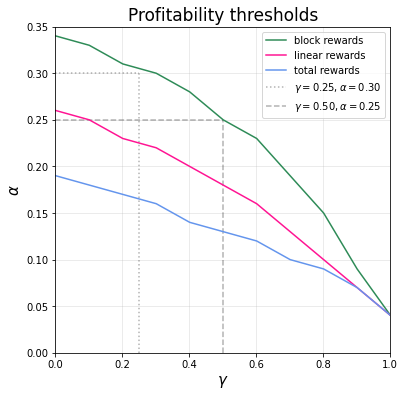

In [701]:
f, ax = plt.subplots(figsize=(6,6))

ax.plot(gammas, b_res, label='block rewards', color='seagreen')
ax.plot(gammas, l_res, label='linear rewards', color='deeppink')
ax.plot(gammas, f_res, label='total rewards', color='cornflowerblue')
# ax.plot(gammas, starting_alphas, color='black')


ax.grid(alpha=0.3)
ax.set_xlabel(r'$\gamma$', size=15)
ax.set_ylabel(r'$\alpha$', size=15)
ax.set_title(r'Profitability thresholds', size=17)

ax.hlines(0.3, xmin=0, xmax=0.25, color='black', linestyles='dotted', alpha=0.3, 
          label=r'$\gamma=0.25,\alpha=0.30$')
ax.vlines(0.25, ymin=0, ymax=0.3, color='black', linestyles='dotted', alpha=0.3)
ax.hlines(0.25, xmin=0, xmax=0.5, color='black', linestyles='--', alpha=0.3, 
          label=r'$\gamma=0.50,\alpha=0.25$')
ax.vlines(0.5, ymin=0, ymax=0.25, color='black', linestyles='--', alpha=0.3)

ax.set_xlim(0,1)
ax.set_ylim(0,.35)

ax.legend()
plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# interpolation

In [206]:
alphas = np.arange(0.01, 0.5, 0.01)
betas = np.arange(1.01, 5.01, 0.5)
gammas = [0.0, 0.5, 1.0]
p_     = 0.
E_     = 4
C_     = 1.
g_     = 0.

In [207]:
subs = {C:C_, E:E_, p:p_}

In [208]:
attack_fixed =  attack_full_fixed.subs({p1:p1_sym}).subs({C:1., p:0.})
attack_lin   =  attack_full_lin.subs({p1:p1_sym}).subs({C:0., p:0.})
attack_two   = ((1/(1-ell))*attack_full_fixed + attack_full_lin).subs({p1:p1_sym}).subs({C:1., p:0.})

In [209]:
o_0p    = 1
o_rest = p1*a*(1-a)/(1-2*a)
orphan_full = p0p * o_0p + o_rest

eq1 = sp.Eq(orphan_full.subs({p1:p1_sym}).subs(subs), ell)

In [211]:
selfish_rews = []
linear_rews  = []
total_rews   = []
for i, a_ in tqdm(enumerate(alphas)):
    bestBeta = 100.
    bestEll  = sp.nsolve(eq1.subs({a:a_, b:bestBeta, g:g_}), ell, 0.1)
    rew      = attack_fixed.subs({a:a_, b:bestBeta, g:g_, ell:bestEll})
    selfish_rews.append(1/(1-bestEll)*rew)

    temp = []
    # betas can start from 0.
    betas = np.arange(0.01, 5.01, 0.5)
    for b_ in betas:
        ell_ = sp.nsolve(eq1.subs({a:a_, b:b_, g:g_}), ell, 0.1)
        temp.append(attack_lin.subs({a:a_, b:b_, g:g_, ell:ell_}))
    bestBeta = betas[np.argmax(temp)]
    bestEll  = sp.nsolve(eq1.subs({a:a_, b:bestBeta, g:g_}), ell, 0.1)
    rew      = attack_lin.subs({a:a_, b:bestBeta, g:g_, ell:bestEll})
    linear_rews.append(1/(1-bestEll)*rew)
    
    temp = []
    # betas can start from 1.
    betas = np.arange(1.01, 5.01, 0.5)
    for b_ in betas:
        ell_ = sp.nsolve(eq1.subs({a:a_, b:b_, g:g_}), ell, 0.1)
        temp.append(attack_two.subs({a:a_, b:b_, g:g_, ell:ell_}))
    bestBeta = betas[np.argmax(temp)]
    bestEll  = sp.nsolve(eq1.subs({a:a_, b:bestBeta, g:g_}), ell, 0.1)
    rew      = attack_two.subs({a:a_, b:bestBeta, g:g_, ell:bestEll})
    total_rews.append(1/(1-bestEll)*rew)

selfish_rews = np.array(selfish_rews)
linear_rews = np.array(linear_rews)
total_rews = np.array(total_rews)
selfish_rews.shape, linear_rews.shape, total_rews.shape

49it [00:15,  3.24it/s]


((49,), (49,), (49,))

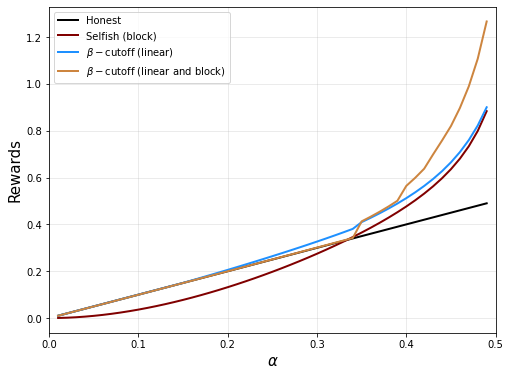

In [214]:
f, ax = plt.subplots(figsize=(8,6))

for ax_ in [ax]:
    ax_.plot(alphas, alphas, label='Honest', color='black', linewidth=2)
    ax_.plot(alphas, selfish_rews, label='Selfish (block)', color='maroon', linewidth=2)
    ax_.plot(alphas, linear_rews, label=r'$\beta-$cutoff (linear)', color='dodgerblue', linewidth=2)
    ax_.plot(alphas, total_rews/2, label=r'$\beta-$cutoff (linear and block)', color='peru', linewidth=2)
    ax_.grid(alpha=0.3)

ax.set_xlabel(r'$\alpha$', size=15)
ax.set_ylabel(r'Rewards', size=15)
ax.set_xlim(0,0.5)
# ax.set_ylim(0,1.)
ax.legend(loc=2)

plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

In [ ]:
# interpolation

alphas = np.arange(0.01, 0.50, 0.01)
betas = np.arange(1.01, 5.01, 0.5)
gammas = [0.0, 0.5, 1.0]
p_     = 0.25
E_     = 4
C_     = 1.
g_     = 0.

subs = {C:C_, E:E_, p:p_}

attack_fixed =  attack_full_fixed.subs({p1:p1_sym}).subs(subs)
attack_lin   =  attack_full_lin.subs({p1:p1_sym}).subs(subs)
attack_two   = ((1/(1-ell))*attack_full_fixed + attack_full_lin).subs({p1:p1_sym}).subs(subs)

o_0p    = 1
o_rest = p1*a*(1-a)/(1-2*a)
orphan_full = p0p * o_0p + o_rest

eq1 = sp.Eq(orphan_full.subs({p1:p1_sym}).subs(subs), ell)

betas

selfish_rews = []
linear_rews  = []
total_rews   = []
for i, a_ in tqdm(enumerate(alphas)):
    bestBeta = 100.
    bestEll  = sp.nsolve(eq1.subs({a:a_, b:bestBeta, g:g_}), ell, 0.1)
    rew      = (1/(1-bestEll))*attack_fixed.subs({a:a_, b:bestBeta, g:g_, ell:bestEll})
    selfish_rews.append(rew)

    temp = []
    for b_ in betas:
        ell_ = sp.nsolve(eq1.subs({a:a_, b:b_, g:g_}), ell, 0.1)
        temp.append(attack_lin.subs({a:a_, b:b_, g:g_, ell:ell_}))
    bestBeta = betas[np.argmax(temp)]
    bestEll  = sp.nsolve(eq1.subs({a:a_, b:bestBeta, g:g_}), ell, 0.1)
    rew      = attack_lin.subs({a:a_, b:bestBeta, g:g_, ell:bestEll})
    linear_rews.append(rew)
    
    temp = []
    for b_ in betas:
        ell_ = sp.nsolve(eq1.subs({a:a_, b:b_, g:g_}), ell, 0.1)
        temp.append(attack_two.subs({a:a_, b:b_, g:g_, ell:ell_}))
    bestBeta = betas[np.argmax(temp)]
    bestEll  = sp.nsolve(eq1.subs({a:a_, b:bestBeta, g:g_}), ell, 0.1)
    rew      = attack_two.subs({a:a_, b:bestBeta, g:g_, ell:bestEll})
    total_rews.append(rew)

selfish_rews = np.array(selfish_rews)
linear_rews = np.array(linear_rews)
total_rews = np.array(total_rews)
selfish_rews.shape, linear_rews.shape, total_rews.shape

f, ax = plt.subplots(figsize=(8,6))

for ax_ in [ax]:
    ax_.plot(alphas, alphas, label='Honest', color='black', linewidth=2)
    ax_.plot(alphas, selfish_rews, label='Selfish (block)', color='maroon', linewidth=2)
    ax_.plot(alphas, linear_rews, label=r'$\beta-$cutoff (linear)', color='dodgerblue', linewidth=2)
    ax_.plot(alphas, total_rews/2, label=r'$\beta-$cutoff (linear and block)', color='peru', linewidth=2)
    ax_.grid(alpha=0.3)

ax.set_xlabel(r'$\alpha$', size=15)
ax.set_ylabel(r'Rewards', size=15)
ax.set_xlim(0,0.5)
# ax.set_ylim(0,1.)
ax.legend(loc=2)

plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

In [65]:
# EXPERIMENT

In [89]:
alphas = np.arange(0.01, 0.5, 0.01)
betas = np.arange(1.01, 5.01, 0.5)
gammas = [0.0, 0.25, 0.5]
p_     = 0.25
E_     = 4
C_     = 1.
g_     = 0.

subs = {C:C_, E:E_, p:p_}

attack_fixed =  attack_full_fixed.subs({p1:p1_sym}).subs(subs)

In [91]:
selfish_rews = []
for g_ in gammas:
    temp = []
    for i, a_ in tqdm(enumerate(alphas)):
        bestBeta = 100.
        bestEll  = sp.nsolve(eq1.subs({a:a_, b:bestBeta, g:g_}), ell, 0.1)
        rew      = attack_fixed.subs({a:a_, b:bestBeta, g:g_, ell:bestEll})
        temp.append(1/(1-bestEll)*rew)
    selfish_rews.append(temp)

selfish_rews = np.array(selfish_rews)
selfish_rews.shape

49it [00:01, 37.49it/s]
49it [00:01, 38.05it/s]
49it [00:01, 38.22it/s]


(3, 49)

In [94]:
def EyalSirer(a_, g_):
    num = a_*((1-a_)**2)*(4*a_+g_*(1-2*a_))-(a_**3)
    den = 1 - a_*(1+(2-a_)*a_)
    return num / den

In [95]:
ES_rews = []
for g_ in gammas:
    temp = []
    for i, a_ in tqdm(enumerate(alphas)):
        temp.append(EyalSirer(a_, g_))
    ES_rews.append(temp)
ES_rews = np.array(ES_rews)
ES_rews.shape

49it [00:00, 54937.42it/s]
49it [00:00, 67229.60it/s]
49it [00:00, 81233.56it/s]


(3, 49)

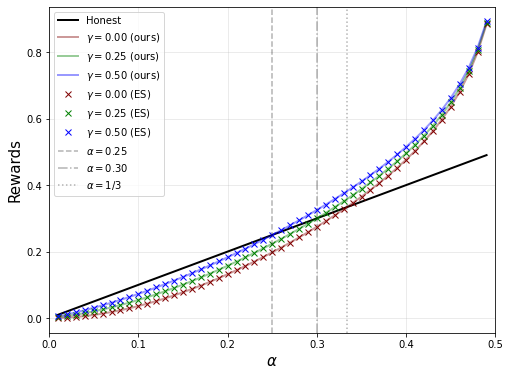

In [100]:
f, ax = plt.subplots(figsize=(8,6))

for ax_ in [ax]:
    ax_.plot(alphas, alphas, label='Honest', color='black', linewidth=2)
    ax_.plot(alphas, selfish_rews[0,:], label=r'$\gamma=0.00$ (ours)', color='maroon', linewidth=2, alpha=0.4)
    ax_.plot(alphas, selfish_rews[1,:], label=r'$\gamma=0.25$ (ours)', color='green', linewidth=2, alpha=0.4)
    ax_.plot(alphas, selfish_rews[2,:], label=r'$\gamma=0.50$ (ours)', color='blue', linewidth=2, alpha=0.4)
    
    ax_.plot(alphas, selfish_rews[0,:], label=r'$\gamma=0.00$ (ES)', color='maroon',
             marker='x', linestyle='none')
    ax_.plot(alphas, selfish_rews[1,:], label=r'$\gamma=0.25$ (ES)', color='green',
             marker='x', linestyle='none')
    ax_.plot(alphas, selfish_rews[2,:], label=r'$\gamma=0.50$ (ES)', color='blue',
             marker='x', linestyle='none')
    ax_.grid(alpha=0.3)

ax.set_xlabel(r'$\alpha$', size=15)
ax.set_ylabel(r'Rewards', size=15)
ax.set_xlim(0,0.5)


ax.axvline(0.25, color='k', alpha=0.3, label=r'$\alpha=0.25$', linestyle='--')
ax.axvline(0.3, color='k', alpha=0.3, label=r'$\alpha=0.30$', linestyle='-.')
ax.axvline(1/3, color='k', alpha=0.3, label=r'$\alpha=1/3$', linestyle='dotted')

ax.legend(loc=2)
plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()